In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import seaborn as sns

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 6,3
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

## 1

* Загрузить файл data_breast.csv. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной “Diagnosis” - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” –malicious). Описание данных доступно на сайте https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [2]:
data = pd.read_csv('data_breast.csv')

In [3]:
data.head().T

,0,1,2,3,4
id,842302,842517,84300903,84348301,84358402
diagnosis,M,M,M,M,M
radius_mean,17.99,20.57,19.69,11.42,20.29
texture_mean,10.38,17.77,21.25,20.38,14.34
perimeter_mean,122.8,132.9,130,77.58,135.1
area_mean,1001,1326,1203,386.1,1297
smoothness_mean,0.1184,0.08474,0.1096,0.1425,0.1003
compactness_mean,0.2776,0.07864,0.1599,0.2839,0.1328
concavity_mean,0.3001,0.0869,0.1974,0.2414,0.198
concave points_mean,0.1471,0.07017,0.1279,0.1052,0.1043


In [4]:
# 33 признака, 569 строк
data.shape

(569, 33)

In [5]:
# один категориальный признак diagnosis (target)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [6]:
# remove Unnamed:32, id
data.drop(['Unnamed: 32', 'id'], axis = 1, inplace=True)

In [7]:
data.shape

(569, 31)

In [8]:
# переведем target признак в бинарный (M = malignant(1), B = benign(0) 
# доброкачественным (значение “B”), либо злокачественным (значение “M”)
trg_binar = {'M': 1, 'B': 0}
data['diagnosis'] = data['diagnosis'].map(trg_binar)

In [9]:
# посмотрим на соотношение target переменной
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [10]:
np.round(data['diagnosis'].value_counts(normalize=True),2)

0    0.63
1    0.37
Name: diagnosis, dtype: float64

## 2

* Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).

In [11]:
# встроенная функция describe
data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [12]:
# MODA (в основном NaN - данные распределены равномерно)
data.iloc[:,1:].mode().T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
radius_mean,12.340000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
texture_mean,14.930000,15.700000,16.840000,16.850000,17.460000,18.220000,18.900000,19.830000,20.520000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
perimeter_mean,82.610000,87.760000,134.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area_mean,512.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoothness_mean,0.100700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
compactness_mean,0.114700,0.120600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
concavity_mean,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
concave points_mean,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
symmetry_mean,0.160100,0.171400,0.171700,0.176900,0.189300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fractal_dimension_mean,0.056670,0.059070,0.059130,0.061130,0.067820,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3

* Выбрать стратегию для работы с пропущенными значениями.

In [13]:
# Unnamed: 32 удалили. Пропущенных значений нет

## 4

* Рассчитать и визуализировать корреляционную матрицу для переменных.

In [14]:
corr = data.corr()

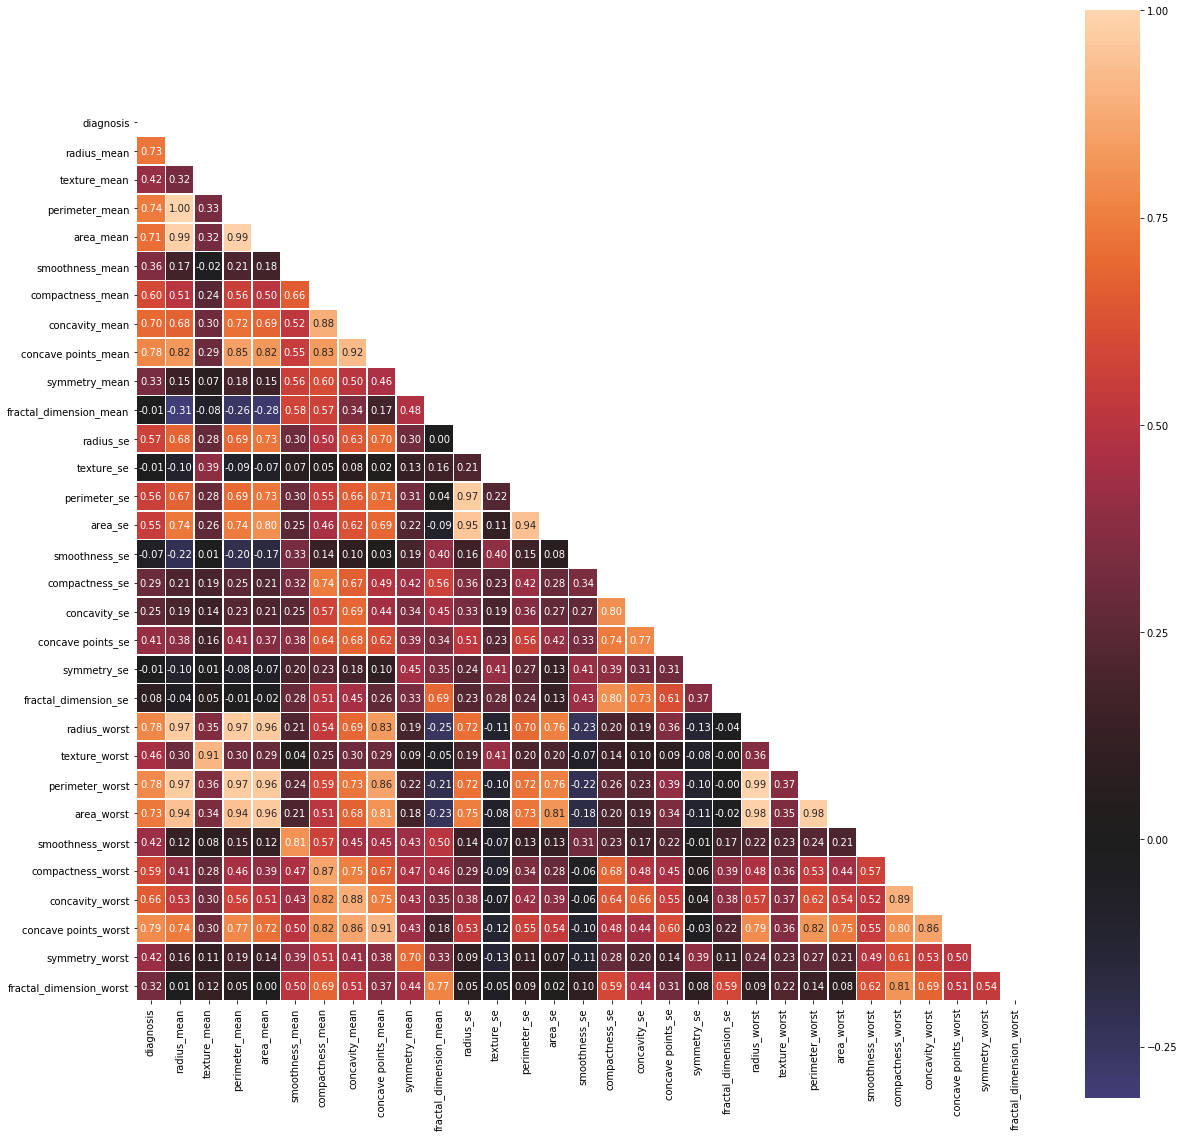

In [15]:
%config InlineBackend.figure_format = 'png'
plt.figure(figsize=(20,20))
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5);

## strong correlations

*radius_mean:
area_mean, perimeter_mean, perimeter_worst, radius_worst, area_worst
texture_mean - texture_worst
concavity_mean - concave points_mean
radius_se - perimeter_se, area_se*
Удалим их и посомтрим на кор. матрицу еще раз

In [16]:
data.drop(['perimeter_mean','area_mean','perimeter_worst','radius_worst','area_worst',
         'texture_worst','concave points_mean','concave points_mean','area_se','perimeter_se'],axis=1,inplace=True)

In [17]:
corr_clean = data.corr()

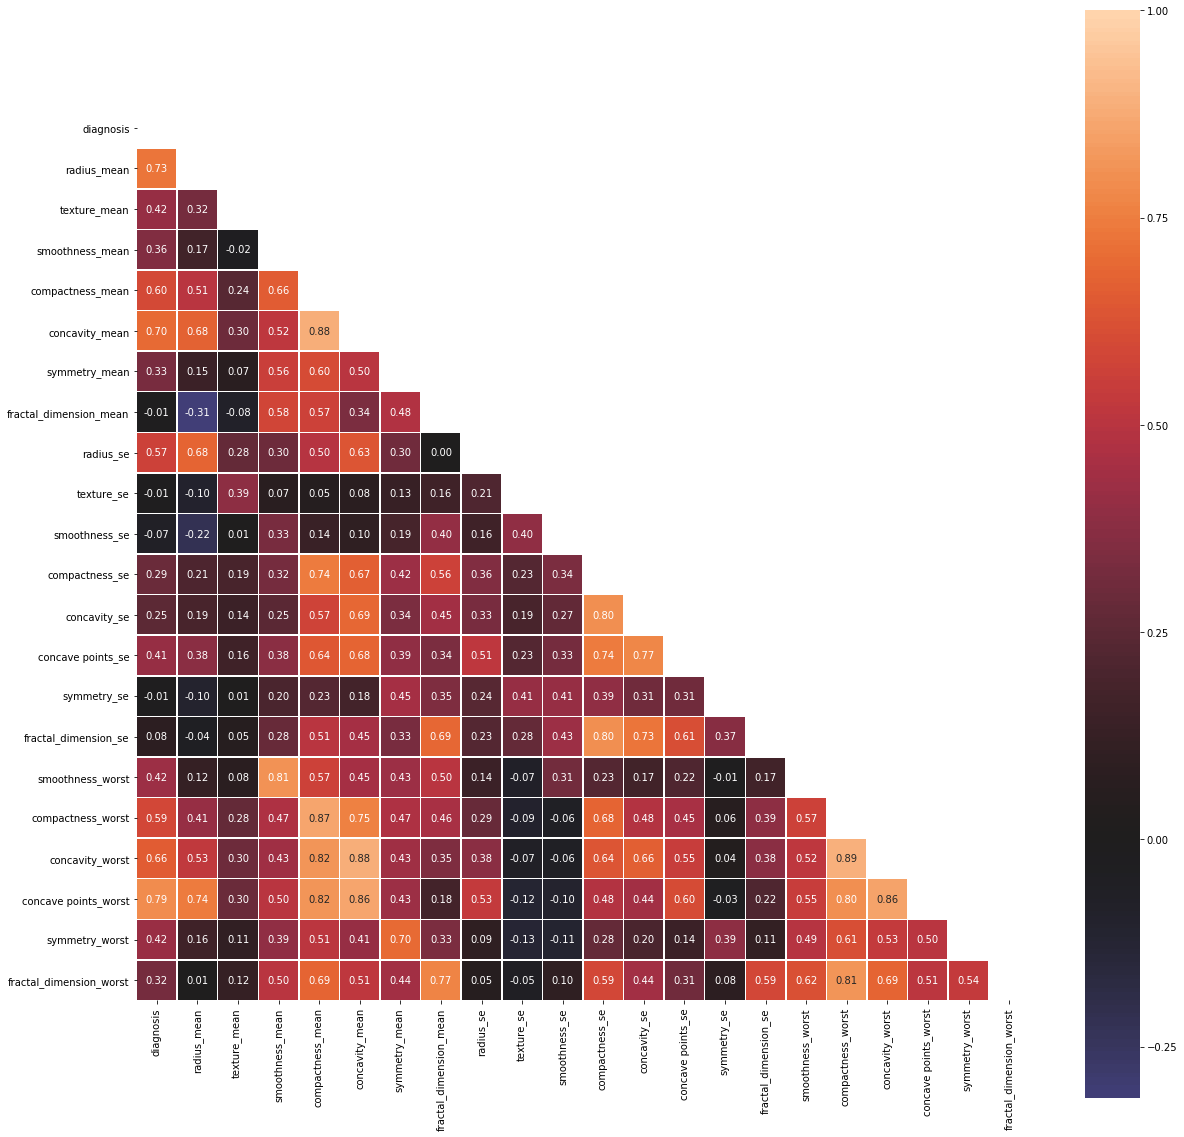

In [18]:
plt.figure(figsize=(20,20))
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr_clean, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True



sns.heatmap(corr_clean, mask=mask, vmax=1, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.5);

Удалим еще compactness_worst, concavity_mean

In [19]:
data.drop(['compactness_worst', 'concavity_mean'], axis = 1, inplace = True)

In [20]:
data.shape

(569, 20)

## 5

* Визуализировать взаимосвязи между переменными (scatter plots, гистограммы, …).

In [21]:
# посмотрим на распределения с помощью countplot

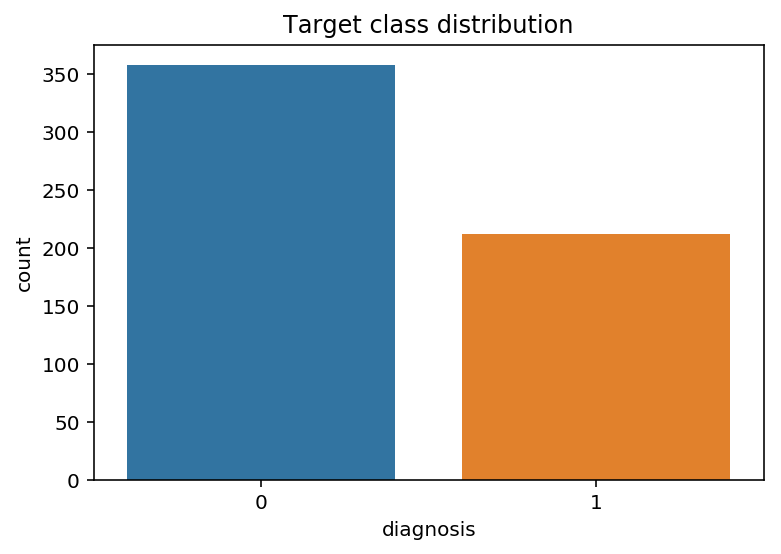

In [22]:
# посмотрим на распределение diagnosis
%config InlineBackend.figure_format = 'retina'
ax = plt.axes()
sns.countplot(x='diagnosis', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

In [23]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [24]:
%config InlineBackend.figure_format = 'retina'

In [25]:
# расмотрим распредления признаков в зависмости от target 0 или 1

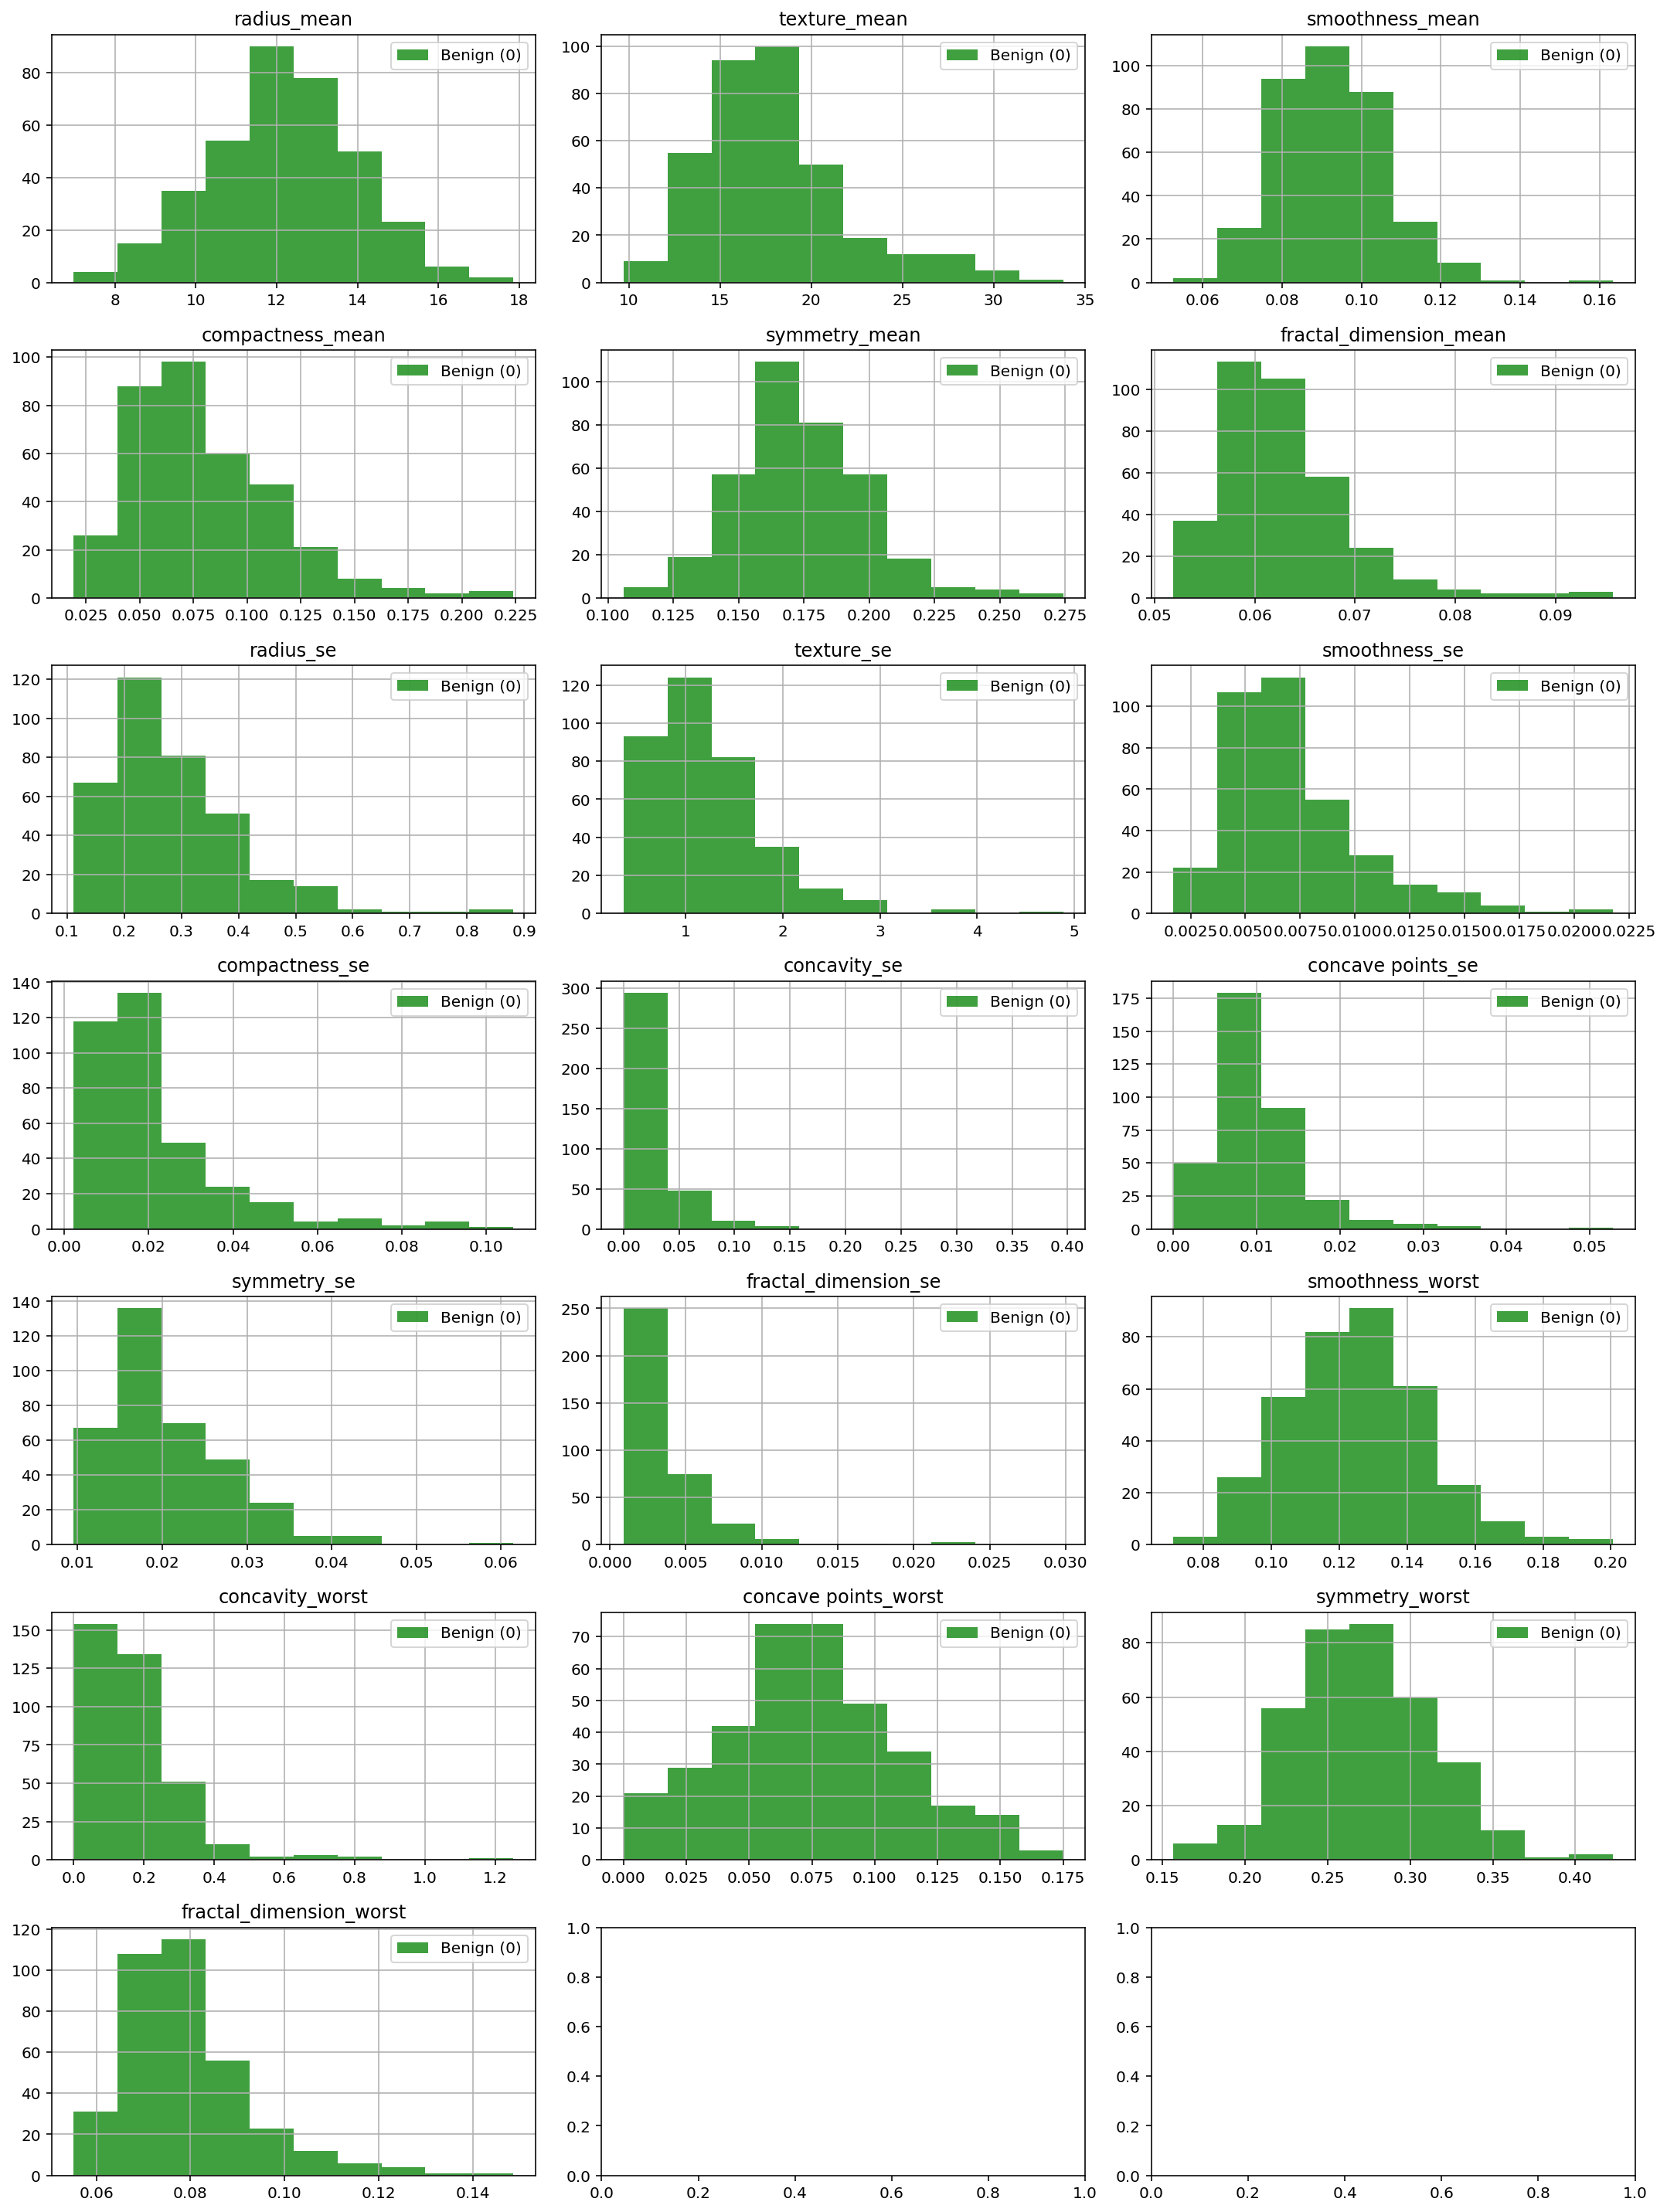

In [26]:
# Bening = 0
fig, ax  =  plt.subplots(7,3, figsize=(15,20))
for col,axis in zip(data.columns[1:],[i for i in ax.flat]):
    data.loc[data['diagnosis']==0,data.columns!='diagnosis'].hist \
    (column=col,ax=axis,alpha=0.75,color='green',label='Benign (0)')
    axis.legend(loc="upper right")
plt.tight_layout()
plt.show()

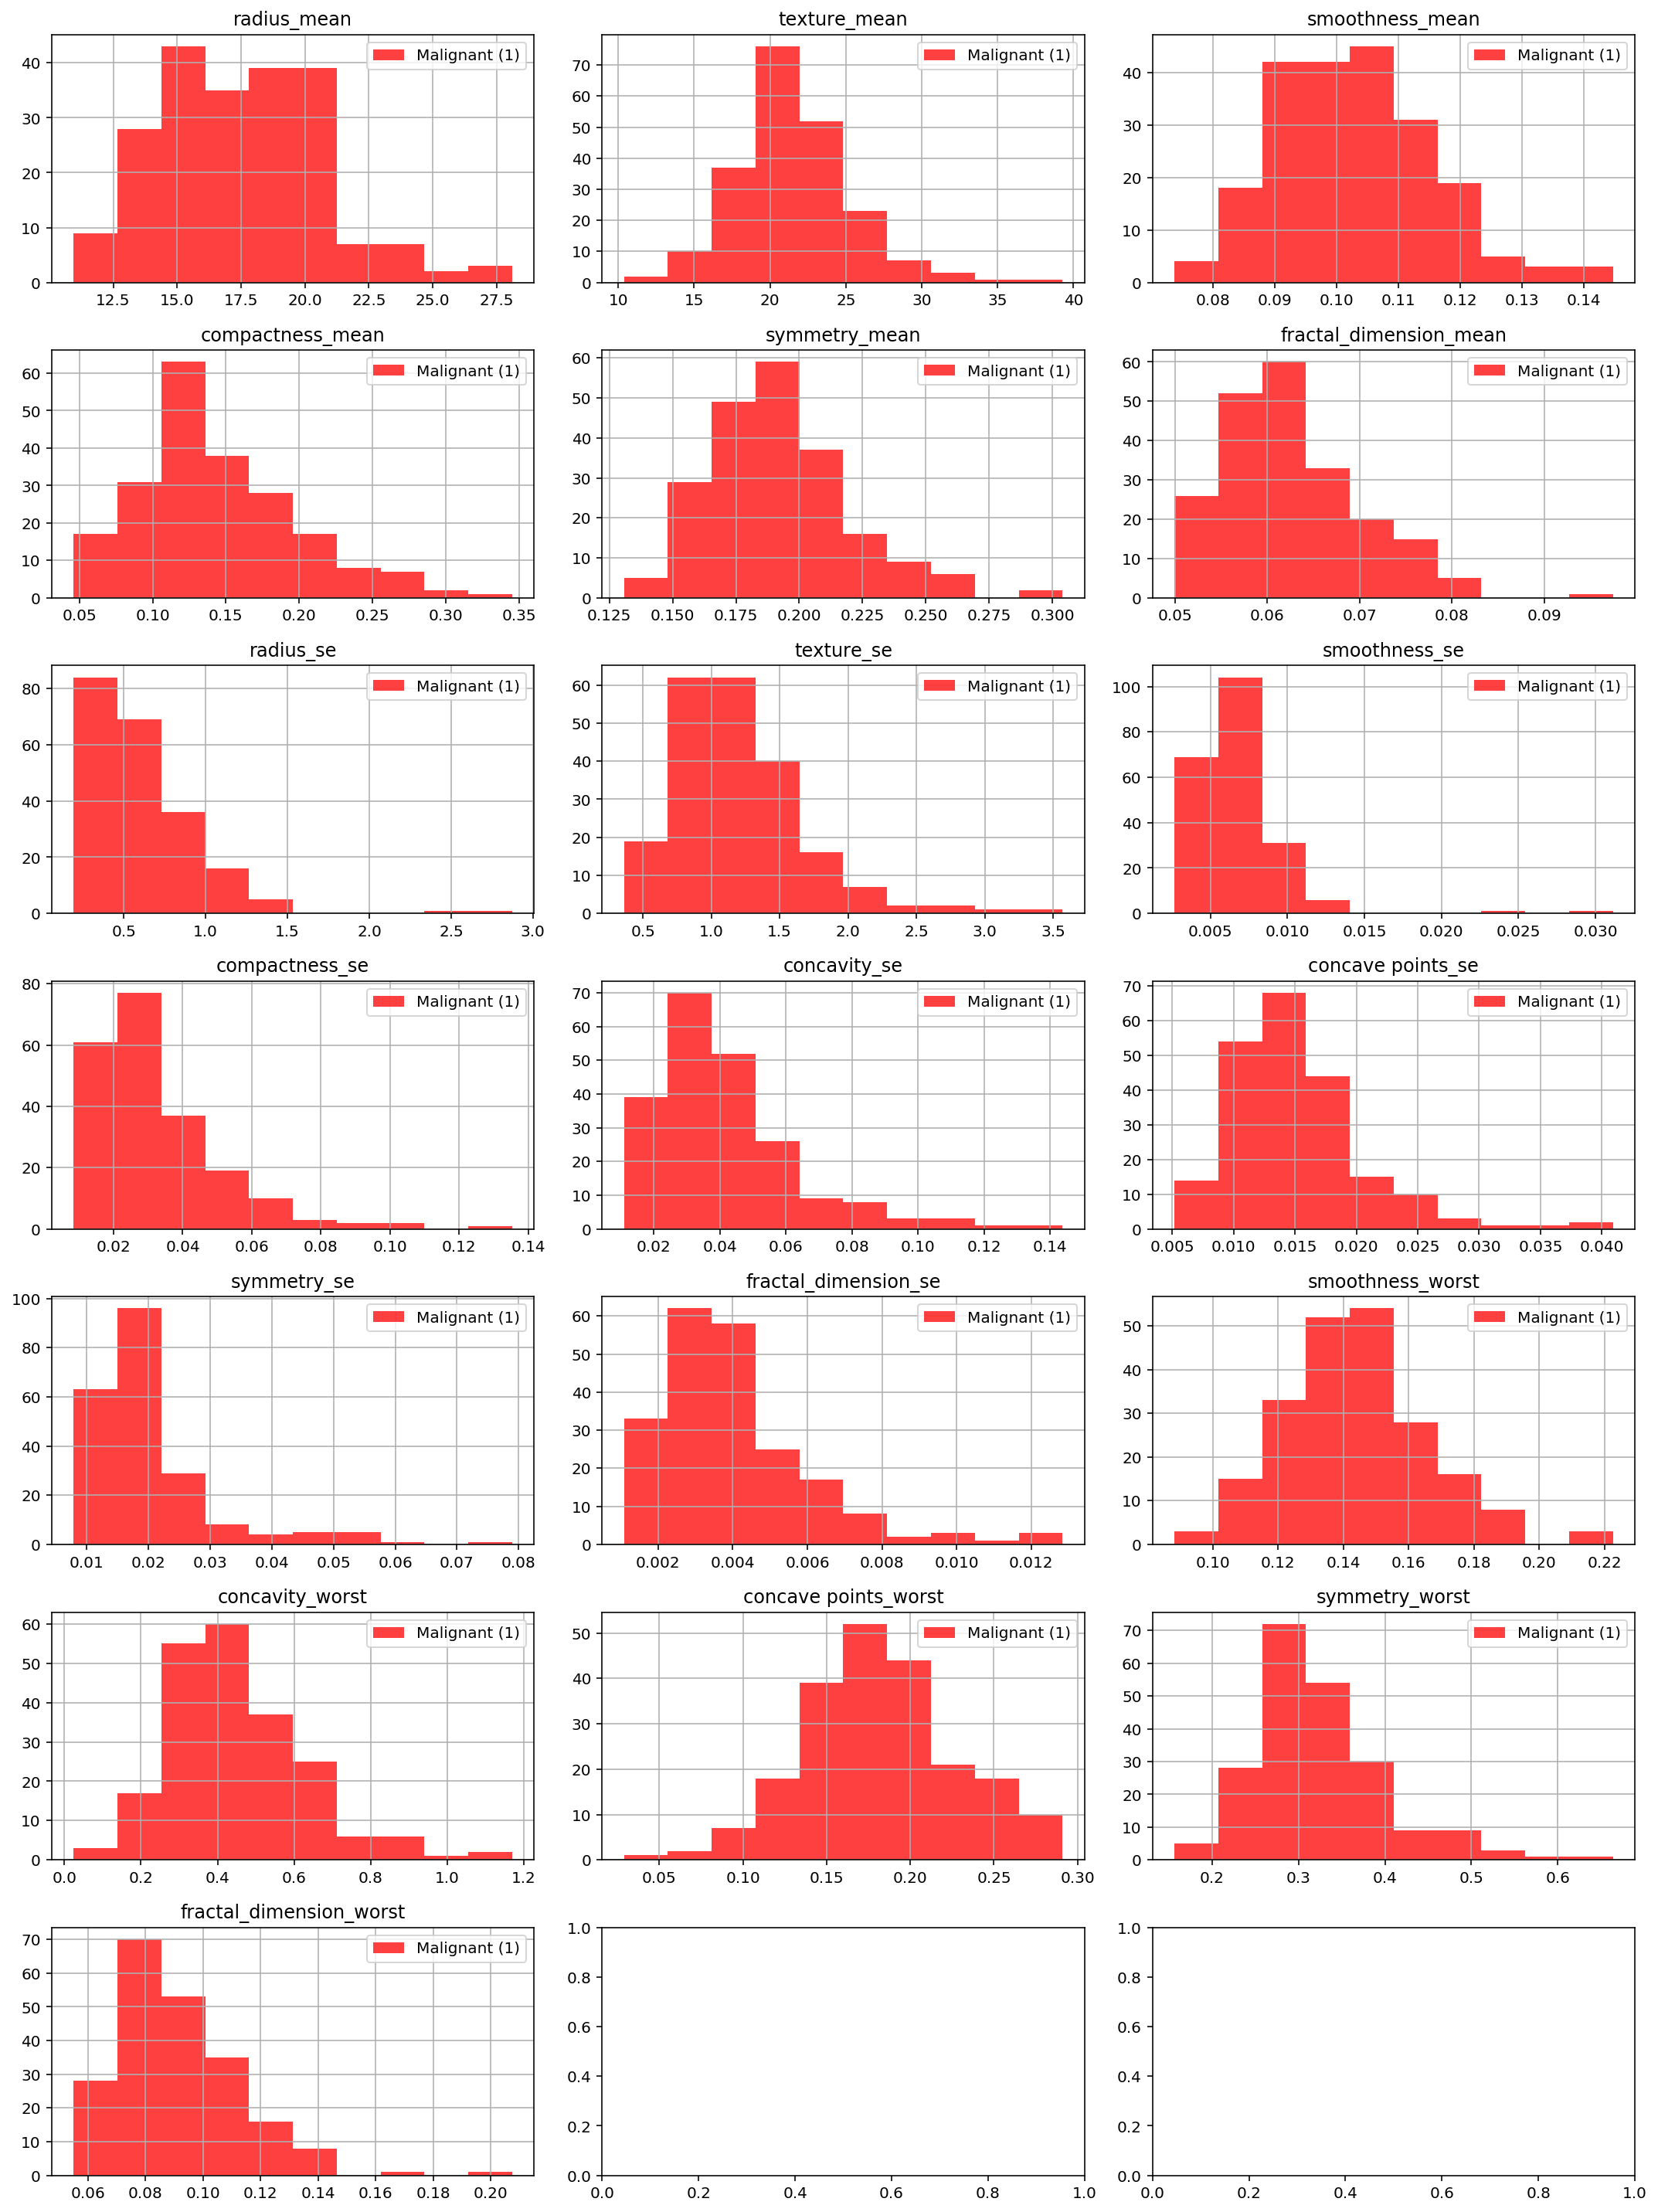

In [27]:
# Malignant = 1
fig, ax  =  plt.subplots(7,3, figsize=(15,20))
for col,axis in zip(data.columns[1:],[i for i in ax.flat]):
    data.loc[data['diagnosis']==1,data.columns!='diagnosis'].hist \
    (column=col,ax=axis,alpha=0.75,color='red',label='Malignant (1)') 
    axis.legend(loc="upper right")
plt.tight_layout()
plt.show()

признаки распределены либо нормально , либо экспоненциально

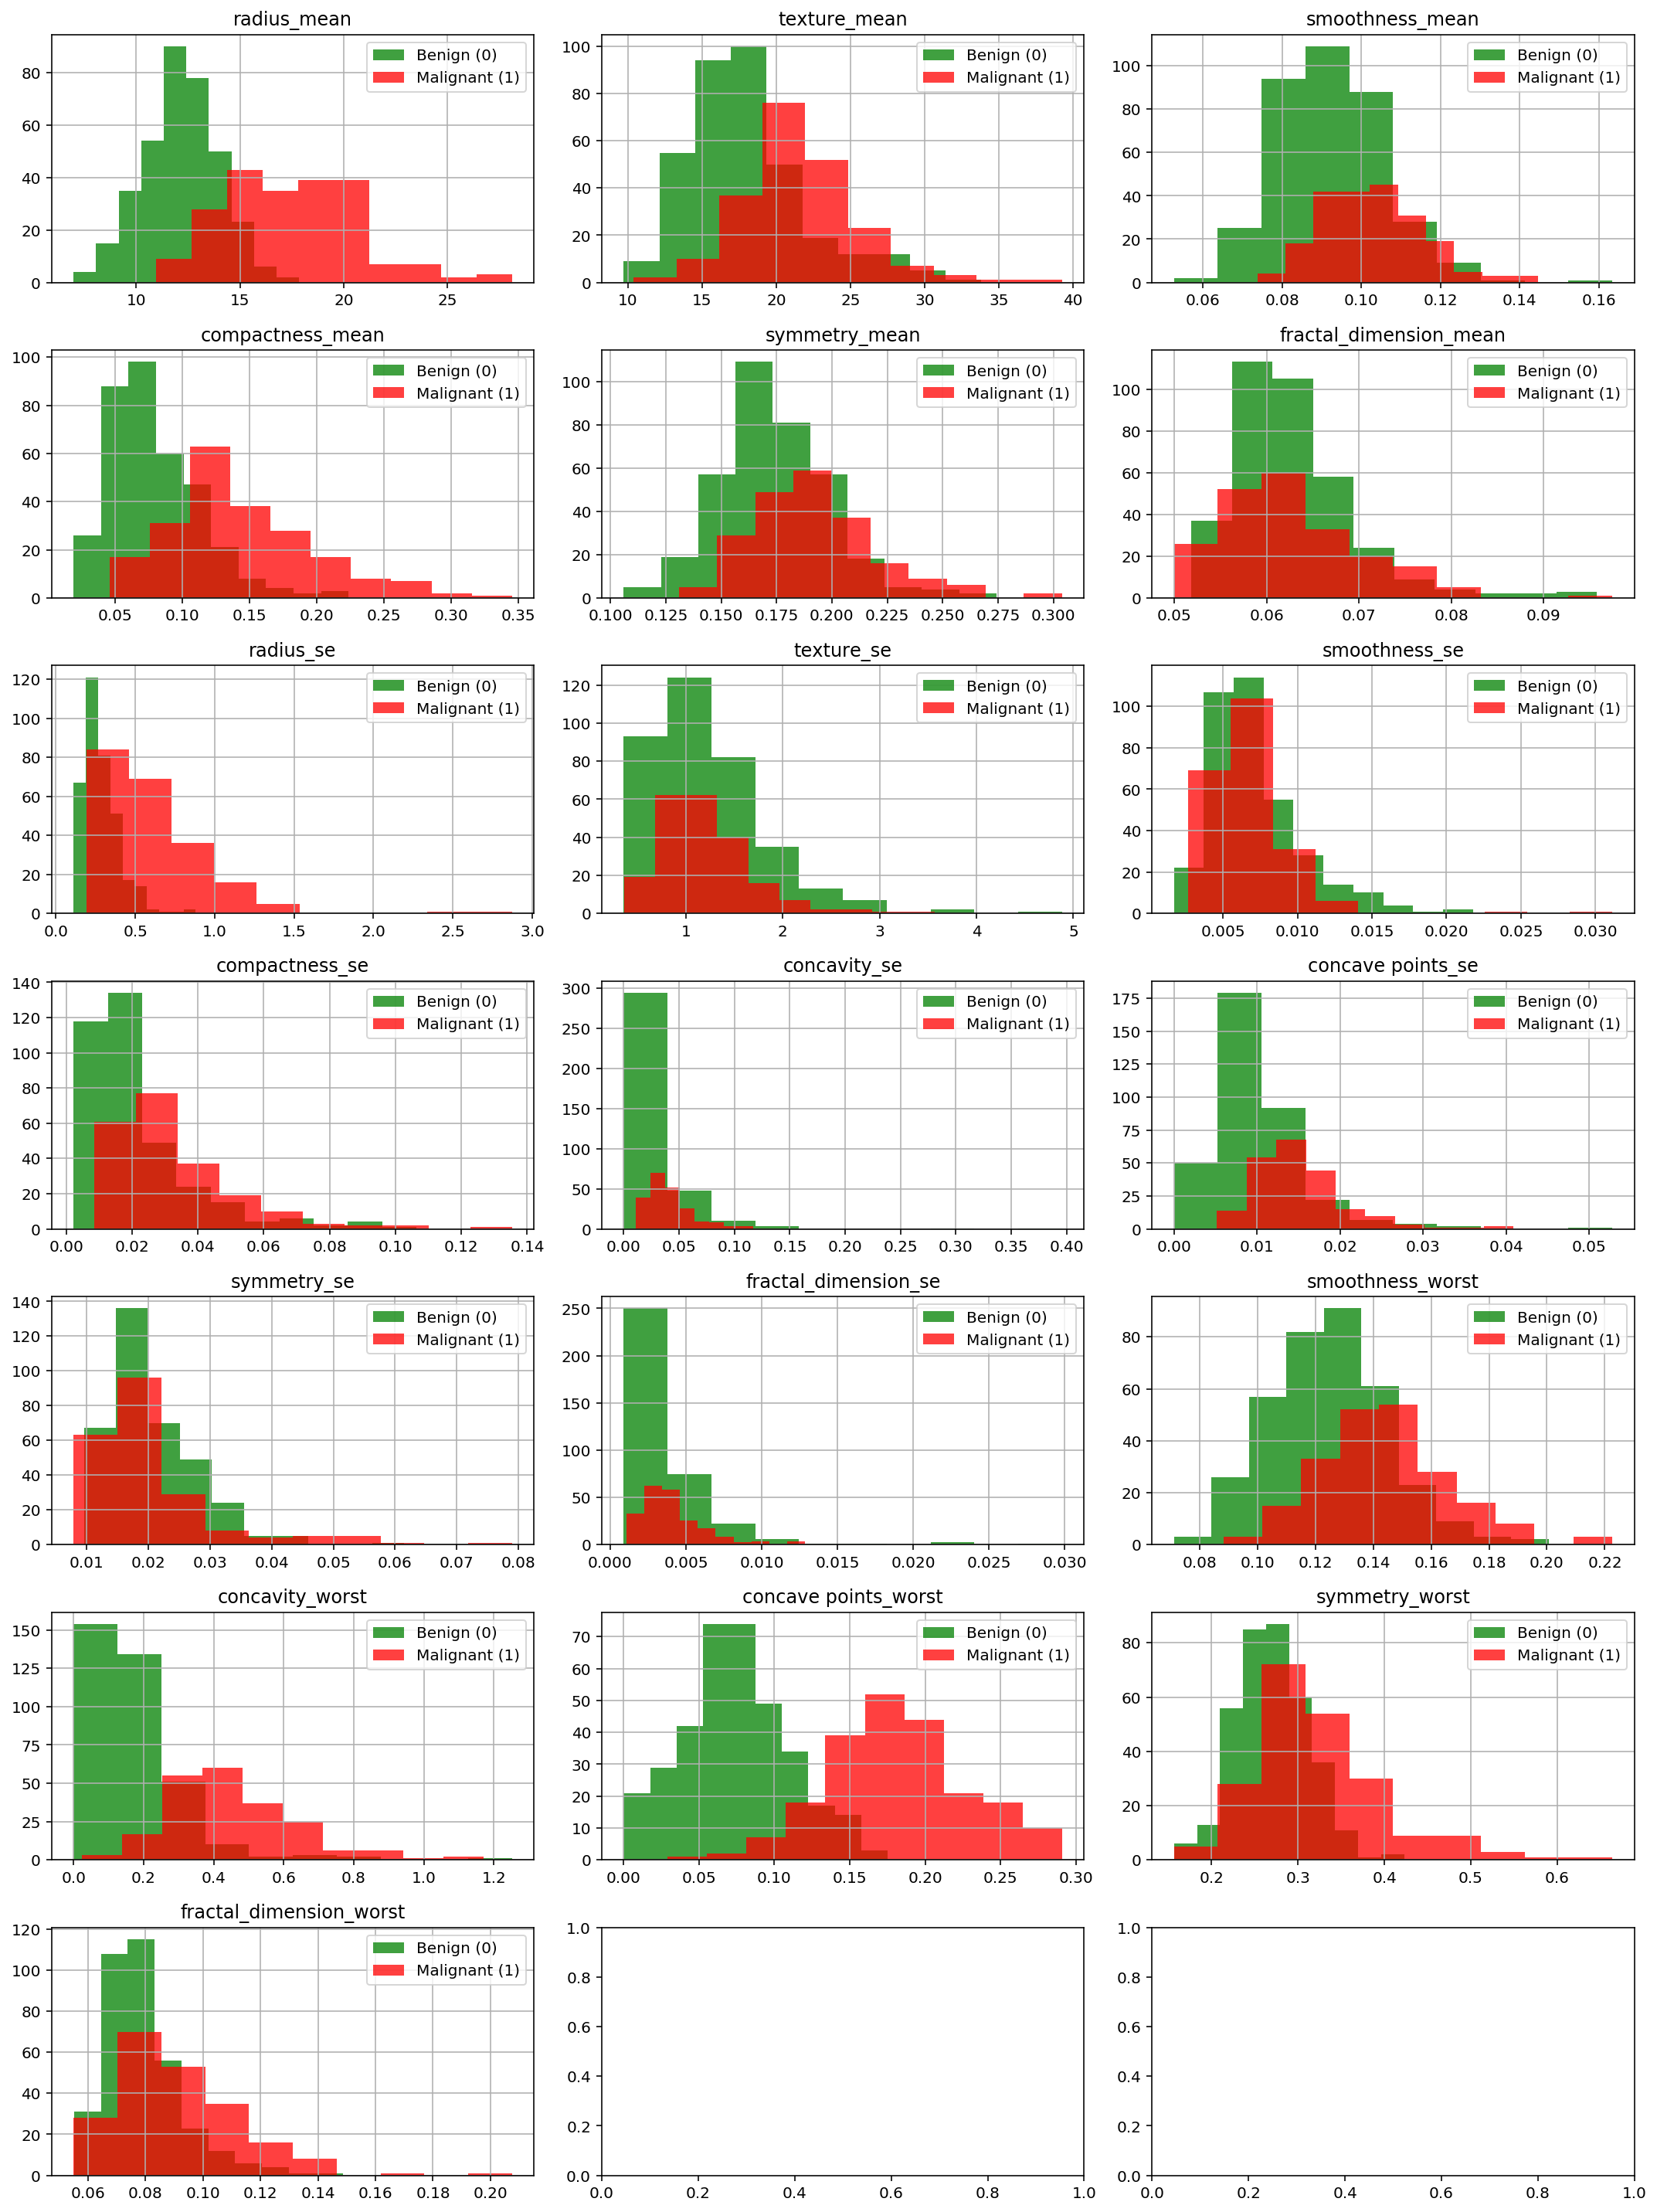

In [28]:
# а теперь вместе
fig, ax  =  plt.subplots(7,3, figsize=(15,20))
for col,axis in zip(data.columns[1:],[i for i in ax.flat]):
    data.loc[data['diagnosis']==0,data.columns!='diagnosis'].hist \
    (column=col,ax=axis,alpha=0.75,color='green',label='Benign (0)')
    data.loc[data['diagnosis']==1,data.columns!='diagnosis'].hist \
    (column=col,ax=axis,alpha=0.75,color='red',label='Malignant (1)') 
    axis.legend(loc="upper right")
plt.tight_layout()
plt.show()
# чем больше значение признака, тем больше злокачественных случаев, за исключением следующих признаков:
# smoothness_mean, symmetry_mean, fractial_dimension_mean, texture_se, smoothness_se, concavity_se
# concave points_se, symmetry_se, fractial_dimension_se, 

In [29]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'smoothness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

## 6

* С помощью статистических методов проверить взаимосвязи между переменными.

In [30]:
# Проверим гипотезу, что у признака radius_mean для доброкачественных и злокачественных среднее равны
# для этого применим Двусторонний t-test (ttest_ind)

Гипотеза $H_0: M_{\text{radius_mean_B}} = M_{\text{radius_mean_M}} $

In [31]:
radius_mean_B = data[data['diagnosis'] == 0]['radius_mean']
radius_mean_M = data[data['diagnosis'] == 1]['radius_mean']

In [32]:
from scipy import stats

In [33]:
# p-value < 0.05. Нулевую гипотезу можно отвергнуть
stats.ttest_ind(radius_mean_B,radius_mean_M)

Ttest_indResult(statistic=-25.435821610057054, pvalue=8.465940572262422e-96)

In [90]:
# проверим гипотезу о нормальности распределения с помощью Теста Шапиро-Вилка
# проверим для признака symmetry_mean
symmetry_mean_B = data[data['diagnosis'] == 0]['symmetry_mean']
print(stats.shapiro(symmetry_mean_B)) # высокий показатель p = .97. Распределение признака соответствует нормальному
symmetry_mean_M = data[data['diagnosis'] == 1]['symmetry_mean']
print(stats.shapiro(symmetry_mean_M)) # высокий показатель p = .96. Распределение признака соответствует нормальному

(0.9740927219390869, 5.1829279072990175e-06)
(0.9648756384849548, 4.0841245208866894e-05)


In [35]:
# посмотрим на распределение fractal_dimension_se с помощью boxplot
# есть выбросы, поэтому проверим нулевую гипотезу с помощью критерия Манна-Уитни

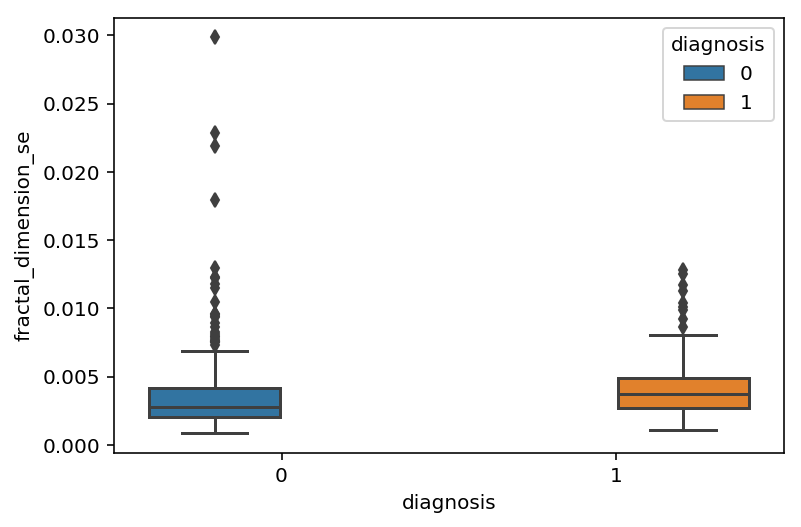

In [36]:
sns.boxplot(x ='diagnosis', y='fractal_dimension_se', hue = 'diagnosis', data = data);

In [37]:
# p-value получился <.05. Нулевую гипотезу можно отвергнуть
fractal_dimension_se_B = data[data['diagnosis'] == 0]['fractal_dimension_se']
fractal_dimension_se_M = data[data['diagnosis'] == 1]['fractal_dimension_se']
stats.mannwhitneyu(fractal_dimension_se_B,fractal_dimension_se_M)

MannwhitneyuResult(statistic=28737.0, pvalue=7.860826754962789e-07)

## 7

* Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих двух подходов даст лучший результат при классификации?

In [38]:
# т.к. у нас нет категориальных признаков и признаков сравнительно немного, будем использовать стратегию
# сокращения размерности.
# Полагю, для нашего датасета лучший результат даст подход сокращения размерности , т,к, нет кат. признаков
data.shape

(569, 20)

## 8

* Рассчитать Feature Selection для выбранных переменных.

In [39]:
import statsmodels.api as sm

In [40]:
data_train = data.drop('diagnosis',axis = 1)

In [41]:
# Итерация 1

In [42]:
data_train = sm.add_constant(data_train)
lm=sm.OLS(data['diagnosis'],data_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.24456153419561388
R^2: 0.7441433224141101


/Users/maxim/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [43]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.2827,0.331,-3.874,0.000,-1.933,-0.632
radius_mean,0.0427,0.009,4.599,0.000,0.024,0.061
texture_mean,0.0140,0.003,4.389,0.000,0.008,0.020
smoothness_mean,0.6552,1.910,0.343,0.732,-3.096,4.407
compactness_mean,-1.3872,0.833,-1.665,0.097,-3.024,0.250
symmetry_mean,-0.3264,0.743,-0.439,0.661,-1.785,1.132
fractal_dimension_mean,-6.4787,5.130,-1.263,0.207,-16.556,3.598
radius_se,0.2382,0.065,3.686,0.000,0.111,0.365
texture_se,0.0345,0.027,1.276,0.203,-0.019,0.088
smoothness_se,13.3739,6.522,2.051,0.041,0.562,26.185


In [44]:
# выкинем symmetry_se так как у него наибольшее p-value
data_train = data_train.drop('symmetry_se',axis = 1)

In [45]:
data_train = sm.add_constant(data_train)
lm=sm.OLS(data['diagnosis'],data_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.24457901086247263
R^2: 0.7441067534442377


In [46]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.2791,0.331,-3.869,0.000,-1.929,-0.630
radius_mean,0.0428,0.009,4.609,0.000,0.025,0.061
texture_mean,0.0141,0.003,4.441,0.000,0.008,0.020
smoothness_mean,0.5457,1.868,0.292,0.770,-3.123,4.215
compactness_mean,-1.3970,0.832,-1.679,0.094,-3.031,0.237
symmetry_mean,-0.2679,0.712,-0.376,0.707,-1.667,1.131
fractal_dimension_mean,-6.7087,5.060,-1.326,0.185,-16.647,3.230
radius_se,0.2341,0.063,3.724,0.000,0.111,0.358
texture_se,0.0324,0.026,1.248,0.212,-0.019,0.083
smoothness_se,12.7118,6.074,2.093,0.037,0.781,24.642


In [47]:
# Итерация 2

In [48]:
# выкинем smoothness_mean так как у него наибольшее p-value
data_train = data_train.drop('smoothness_mean',axis = 1)

In [49]:
data_train = sm.add_constant(data_train)
lm=sm.OLS(data['diagnosis'],data_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.24459798571741284
R^2: 0.7440670466389248


In [50]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.2771,0.330,-3.867,0.000,-1.926,-0.628
radius_mean,0.0431,0.009,4.670,0.000,0.025,0.061
texture_mean,0.0139,0.003,4.497,0.000,0.008,0.020
compactness_mean,-1.3324,0.801,-1.663,0.097,-2.906,0.242
symmetry_mean,-0.2278,0.698,-0.326,0.744,-1.599,1.144
fractal_dimension_mean,-6.4044,4.947,-1.295,0.196,-16.122,3.313
radius_se,0.2350,0.063,3.746,0.000,0.112,0.358
texture_se,0.0336,0.026,1.310,0.191,-0.017,0.084
smoothness_se,12.3743,5.958,2.077,0.038,0.671,24.077
compactness_se,-3.1840,1.785,-1.784,0.075,-6.690,0.322


In [51]:
# Итерация 3

In [52]:
# выкинем symmetry_mean так как у него наибольшее p-value
data_train = data_train.drop('symmetry_mean',axis = 1)

In [53]:
data_train = sm.add_constant(data_train)
lm=sm.OLS(data['diagnosis'],data_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.2446216089860525
R^2: 0.7440176082524783


In [54]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.2979,0.324,-4.009,0.000,-1.934,-0.662
radius_mean,0.0433,0.009,4.712,0.000,0.025,0.061
texture_mean,0.0140,0.003,4.533,0.000,0.008,0.020
compactness_mean,-1.4039,0.770,-1.823,0.069,-2.917,0.109
fractal_dimension_mean,-6.4627,4.940,-1.308,0.191,-16.166,3.241
radius_se,0.2322,0.062,3.739,0.000,0.110,0.354
texture_se,0.0327,0.025,1.284,0.200,-0.017,0.083
smoothness_se,12.2430,5.940,2.061,0.040,0.576,23.910
compactness_se,-3.0771,1.753,-1.755,0.080,-6.521,0.367
concavity_se,-3.2185,1.101,-2.922,0.004,-5.382,-1.055


In [55]:
# Итерация 4

In [56]:
# выкинем fractal_dimension_se так как у него наибольшее p-value
data_train = data_train.drop('fractal_dimension_se',axis = 1)

In [57]:
data_train = sm.add_constant(data_train)
lm=sm.OLS(data['diagnosis'],data_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.24486528599348442
R^2: 0.7435073664017053


In [58]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.4238,0.301,-4.734,0.000,-2.015,-0.833
radius_mean,0.0459,0.009,5.196,0.000,0.029,0.063
texture_mean,0.0138,0.003,4.490,0.000,0.008,0.020
compactness_mean,-1.5587,0.756,-2.062,0.040,-3.044,-0.074
fractal_dimension_mean,-5.2812,4.810,-1.098,0.273,-14.730,4.168
radius_se,0.2351,0.062,3.788,0.000,0.113,0.357
texture_se,0.0348,0.025,1.369,0.172,-0.015,0.085
smoothness_se,12.8321,5.913,2.170,0.030,1.216,24.448
compactness_se,-2.3595,1.614,-1.462,0.144,-5.530,0.811
concavity_se,-2.7523,1.008,-2.731,0.007,-4.732,-0.773


In [59]:
# Итерация 5

In [60]:
# выкинем fractal_dimension_mean так как у него наибольшее p-value
data_train = data_train.drop('fractal_dimension_mean',axis = 1)

In [61]:
data_train = sm.add_constant(data_train)
lm=sm.OLS(data['diagnosis'],data_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.24513200464198218
R^2: 0.7429482946923273


In [62]:
# после удаления фич RMSE,R^2 не сильно отличаются 

## 9, 10

* Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2 алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и вывести вероятность каждого класса.
* Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

In [64]:
y = data['diagnosis'].copy()
X = data.drop('diagnosis',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

<Figure size 576x864 with 0 Axes>

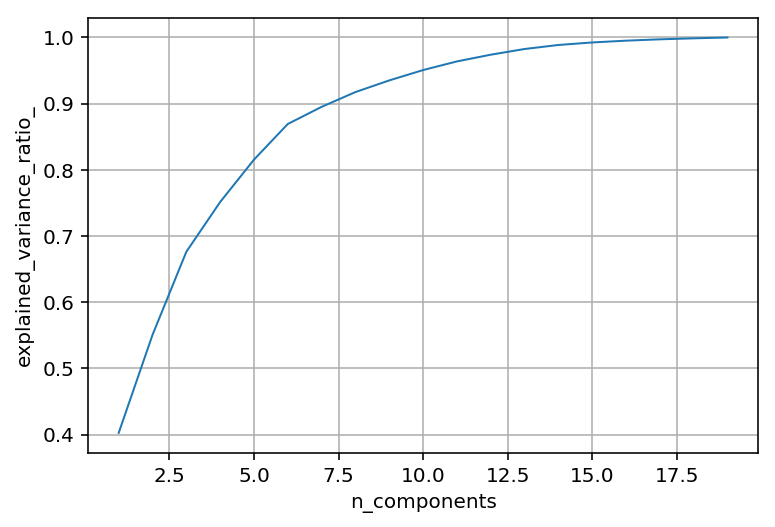

<Figure size 576x864 with 0 Axes>

In [66]:

from sklearn.decomposition import PCA
pca = PCA().fit(scaler.fit_transform(X_train))

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=1)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.figure(figsize=(8,12))

In [67]:
# по графику видно , что 15 компонент объясняют уже больше 90% дисперсии

In [68]:
# проверим это еще раз

In [69]:
X_train_scaled = scaler.fit_transform(X_train)

In [70]:
pca = PCA(n_components=19)

In [71]:
X_pca = pca.fit_transform(X_train_scaled)

In [72]:
X_pca.shape

(398, 19)

In [73]:
# 15 компонент оставляем
for i in range(1, X_pca.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.403
n-components=2, explained variance 0.551
n-components=3, explained variance 0.676
n-components=4, explained variance 0.751
n-components=5, explained variance 0.815
n-components=6, explained variance 0.869
n-components=7, explained variance 0.895
n-components=8, explained variance 0.918
n-components=9, explained variance 0.935
n-components=10, explained variance 0.951
n-components=11, explained variance 0.964
n-components=12, explained variance 0.974
n-components=13, explained variance 0.983
n-components=14, explained variance 0.989
n-components=15, explained variance 0.992
n-components=16, explained variance 0.995
n-components=17, explained variance 0.997
n-components=18, explained variance 0.999
n-components=19, explained variance 1.000


In [74]:
pca = PCA(n_components=15)
pca.fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

In [75]:
X_train_pca = X_pca

In [76]:
# Логистическая регрессия

In [77]:
# сделаем кросс-валидацию
from sklearn.model_selection import cross_val_score
x = X_train_pca.copy()
y = y_train.copy()
logreg = LogisticRegression()
scores = cross_val_score(logreg,x,y,cv=5)

/Users/maxim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maxim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

In [78]:
scores, scores.mean() # разброса сильного нет, качество нашей модели не сильно зависит от того , как разбивать модель

(array([0.975     , 0.975     , 0.9625    , 0.9625    , 0.98717949]),
 0.9724358974358974)

In [79]:
X_test_scaled = scaler.fit_transform(X_test)

In [80]:
pca.fit(X_test_scaled)

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [81]:
X_pca_t = pca.transform(X_test_scaled)

In [82]:
X_test_pca = X_pca_t

In [83]:
logreg.fit(X_train_pca,y_train)
y_pred_logreg_test = logreg.predict_proba(X_test_pca)[:, 1]
y_pred_logreg_train = logreg.predict_proba(X_train_pca)[:, 1]
roc_auc_test = np.round(roc_auc_score(y_test, y_pred_logreg_test),2)
roc_auc_train = np.round(roc_auc_score(y_train, y_pred_logreg_train),2)

print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.97


/Users/maxim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [84]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [85]:
accuracy_log = accuracy_score(y_test,y_pred_logreg_test.round())
f1_score_log = f1_score(y_test,y_pred_logreg_test.round())
precision_score_log = precision_score(y_test,y_pred_logreg_test.round())
recall_score_log = recall_score(y_test,y_pred_logreg_test.round())
print(f'Accuracy: {accuracy_log:.2f}')
print(f'F1_Score: {f1_score_log:.2f}')
print(f'Precision_Score: {precision_score_log:.2f}')
print(f'Recall_Score: {recall_score_log:.2f}')

Accuracy: 0.89
F1_Score: 0.85
Precision_Score: 0.82
Recall_Score: 0.89


In [86]:
# xgboost

In [87]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(X_train_pca, y_train)
y_train_predict = xgb.predict_proba(X_train_pca)[:, 1]
y_test_predict = xgb.predict_proba(X_test_pca)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  1.0
Test:  0.95


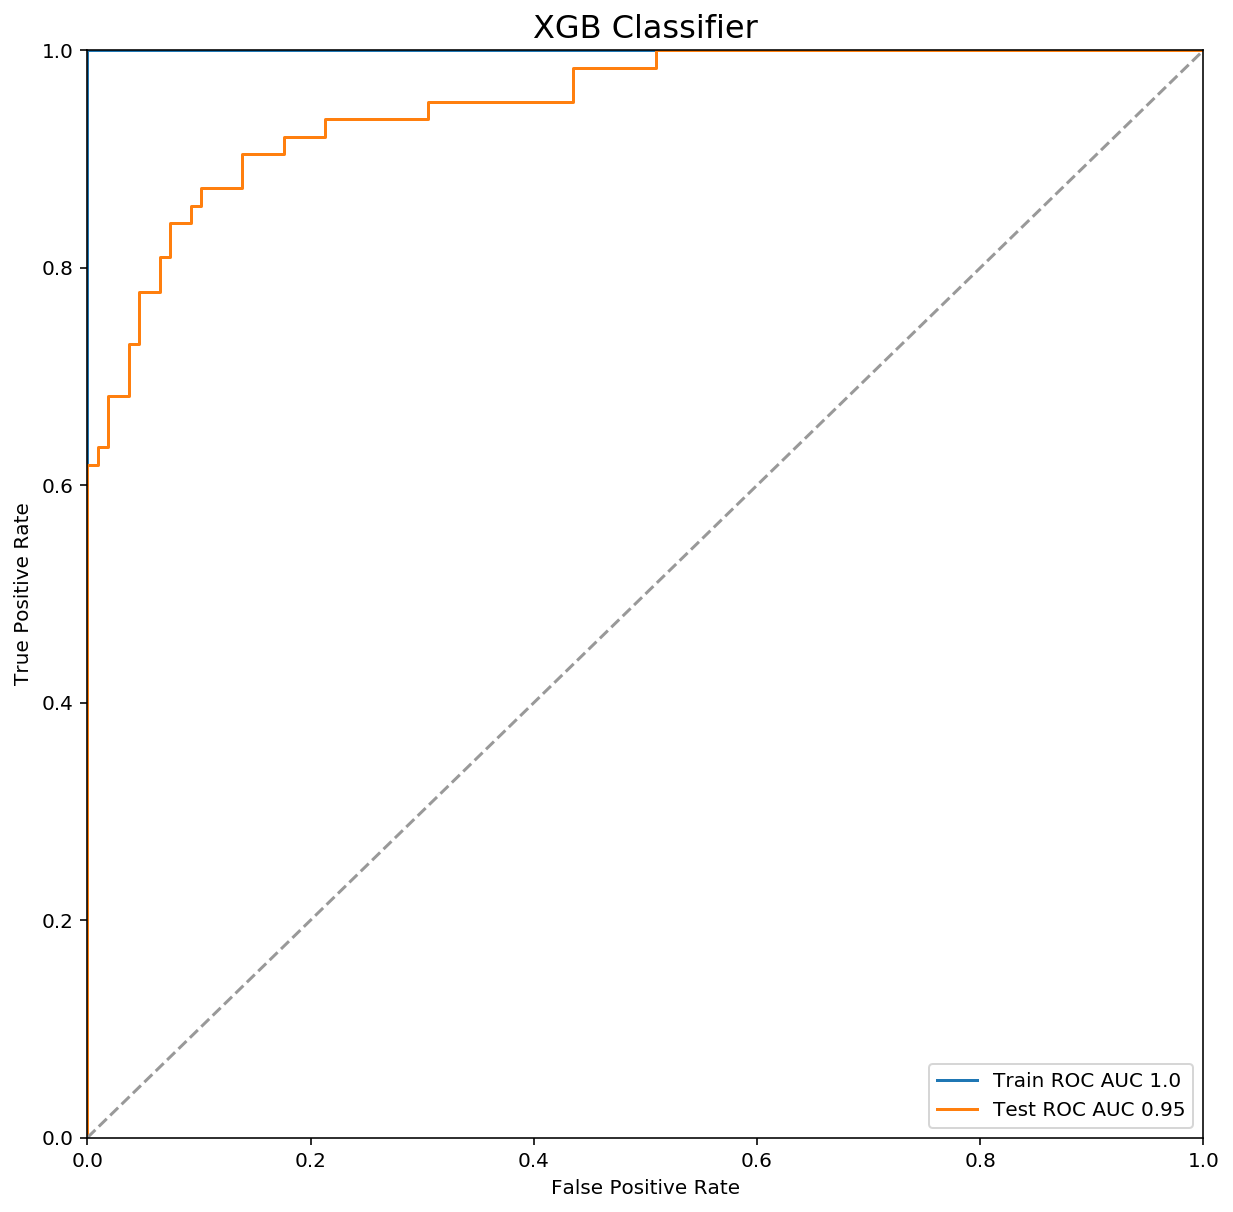

In [88]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [89]:
accuracy_log = accuracy_score(y_test,y_test_predict.round())
f1_score_log = f1_score(y_test,y_test_predict.round())
precision_score_log = precision_score(y_test,y_test_predict.round())
recall_score_log = recall_score(y_test,y_test_predict.round())
print(f'Accuracy: {accuracy_log:.2f}')
print(f'F1_Score: {f1_score_log:.2f}')
print(f'Precision_Score: {precision_score_log:.2f}')
print(f'Recall_Score: {recall_score_log:.2f}')

Accuracy: 0.88
F1_Score: 0.84
Precision_Score: 0.81
Recall_Score: 0.87
